In [65]:


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns

%matplotlib inline



In [66]:
pip install scikit-learn==0.22

Note: you may need to restart the kernel to use updated packages.


In [67]:
#downloading the necessary data

!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv



--2021-01-02 14:21:10--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2021-01-02 14:21:10 (305 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [68]:
#loading data
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [69]:
df.shape

(346, 10)

In [70]:
#Changing the format of dates

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()





,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# 1. Feature engineering

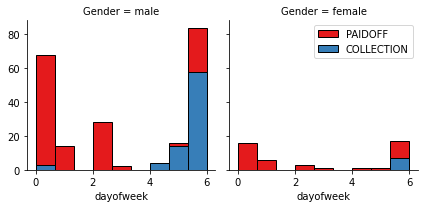

In [71]:
#Visualizing the PAIDOFF RATIO it can be concluded that people very often dont pay it off if they get the loan at the end of the week. A threshold can be set to values less then day 4:

df['dayofweek'] = df['effective_date'].dt.dayofweek
binarizations = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=binarizations, ec="k")
g.axes[-1].legend()
plt.show()



# 1.1. Feature engineer - One Hot Encoding section

In [72]:
# Binarization of "weekend" feature:

df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()



,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [73]:
#Binarizing gender:

df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()



,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [74]:
#Binarization of education and transforming the original dataframe:

Feature_final = df[['Principal','terms','age','Gender','weekend']]
Feature_final = pd.concat([Feature_final, pd.get_dummies(df['education'])], axis=1)
Feature_final.drop(['Master or Above'], axis = 1,inplace=True)
Feature_final.head()



,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [75]:
#Creation of training data "X"

X = Feature_final
X[0:5]



,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [76]:
#Creation of training data "Y"

y = df['loan_status'].values
y[0:5]



array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [77]:
#Data Normalization

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]



array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# 2. Building Clustering Models

In [90]:
#Splitting the starting data to train and test set (80% - 20%)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Training dataset:', x_train.shape,  y_train.shape)
print ('Test dataset:', x_test.shape,  y_test.shape)



Training dataset: (276, 8) (276,)
Test dataset: (70, 8) (70,)


# 2.1 K-nearesrt neighbors classifier

In [91]:
#K-nearesrt neighbors classifier
for k in range(1, 10):
    KNN_model  = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
    KNN_yhat = knn_model.predict(x_test)
    print("In case of K = {} accuracy = {}".format(k,accuracy_score(y_test,KNN_yhat)))

In case of K = 1 accuracy = 0.7571428571428571
In case of K = 2 accuracy = 0.7571428571428571
In case of K = 3 accuracy = 0.7571428571428571
In case of K = 4 accuracy = 0.7571428571428571
In case of K = 5 accuracy = 0.7571428571428571
In case of K = 6 accuracy = 0.7571428571428571
In case of K = 7 accuracy = 0.7571428571428571
In case of K = 8 accuracy = 0.7571428571428571
In case of K = 9 accuracy = 0.7571428571428571


In [97]:
#Mesuring the  priciosity of the KNN model at the best K-value(7) using Jaccard and F1 methods:

best_KNN_model = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)
best_KNN_model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

print("Training dataset Jaccard Accuracy): ", metrics.accuracy_score(y_train, best_KNN_model.predict(x_train)))
print("Test dataset Jaccard Accuracy): ", metrics.accuracy_score(y_test, KNN_yhat))



print("Training dataset Accuracy (F1): ", f1_score(y_train, best_KNN_model.predict(x_train), average='weighted'))
print("Test dataset Accuracy (F1): ", f1_score(y_test, best_KNN_model.predict(x_test), average='weighted'))


Training dataset Jaccard Accuracy):  0.8079710144927537
Test dataset Jaccard Accuracy):  0.7571428571428571
Training dataset Accuracy (F1):  0.8000194668761034
Test dataset Accuracy (F1):  0.7766540244416351


# 2.2. Decision tree classifier

In [99]:
#Decision tree classifier

from sklearn.tree import DecisionTreeClassifier
for d in range(1,10):
    dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = d).fit(x_train, y_train)
    dt_yhat = dt.predict(x_test)
    print("In case of depth = {}  the accuracy score is {} ".format(d, accuracy_score(y_test, dt_yhat)))

In case of depth = 1  the accuracy score is 0.7857142857142857 
In case of depth = 2  the accuracy score is 0.7857142857142857 
In case of depth = 3  the accuracy score is 0.6142857142857143 
In case of depth = 4  the accuracy score is 0.6142857142857143 
In case of depth = 5  the accuracy score is 0.6428571428571429 
In case of depth = 6  the accuracy score is 0.7714285714285715 
In case of depth = 7  the accuracy score is 0.7571428571428571 
In case of depth = 8  the accuracy score is 0.7571428571428571 
In case of depth = 9  the accuracy score is 0.6571428571428571 


In [82]:
## Building the best model with best value of depth 2

best_dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2).fit(x_train, y_train)
best_dt_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [101]:
#Mesuring the  priciosity of the Decision Tree model at the best depth value(2) using Jaccard and F1 methods:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_similarity_score



print("Training dataset Jaccard Accuracy: ", jaccard_similarity_score(y_train, best_dt_model.predict(x_train)))
print("Test dataset Jaccard Accuracy: ", jaccard_similarity_score(y_test, best_dt_model.predict(x_test)))


print("Training dataset Accuracy (F1): ", f1_score(y_train, best_dt_model.predict(x_train), average='weighted'))
print("Test dataset Accuracy (F1): ", f1_score(y_test, best_dt_model.predict(x_test), average='weighted'))

Training dataset Jaccard Accuracy:  0.7427536231884058
Test dataset Jaccard Accuracy:  0.7857142857142857
Training dataset Accuracy (F1):  0.6331163939859591
Test dataset Accuracy (F1):  0.6914285714285714


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)




# 2.3. Support Vector Machine Classifier




In [102]:
#Modelling and classification with Support vector Machine:
from sklearn import svm 
from sklearn.metrics import f1_score
for k in ('linear', 'poly', 'rbf','sigmoid'):
    svm_model = svm.SVC( kernel = k).fit(x_train,y_train)
    svm_yhat = svm_model.predict(x_test)
    print("In Case of kernel: {}, the f1 score is: {}".format(k,f1_score(y_test,svm_yhat, average='weighted')))

In Case of kernel: linear, the f1 score is: 0.6914285714285714
In Case of kernel: poly, the f1 score is: 0.7064793130366899
In Case of kernel: rbf, the f1 score is: 0.7275882012724117
In Case of kernel: sigmoid, the f1 score is: 0.6892857142857144


In [103]:
#best SVM with kernel = rbf
best_svm = svm.SVC(kernel='rbf').fit(x_train,y_train)
best_svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [104]:
#Mesuring the  priciosity of the SVM  model at the best point, kernel = rbf
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

print("Training dataset Jaccard Accuracy: ", jaccard_similarity_score(y_train, best_svm.predict(x_train)))
print("Test dataset Jaccard Accuracy: ", jaccard_similarity_score(y_test, best_svm.predict(x_test)))

print("Training dataset Accuracy (F1): ", f1_score(y_train, best_svm.predict(x_train), average='weighted'))
print("Test dataset Accuracy (F1): ", f1_score(y_test, best_svm.predict(x_test), average='weighted'))

Training dataset Jaccard Accuracy:  0.782608695652174
Test dataset Jaccard Accuracy:  0.7428571428571429
Training dataset Accuracy (F1):  0.7682165861513688
Test dataset Accuracy (F1):  0.7275882012724117


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# 2.4. Logistic regression classifier


In [105]:
#Building logistic regression classifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss
for k in ('lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'):
    lr_model = LogisticRegression(C = 0.01, solver = k).fit(x_train, y_train)
    lr_yhat = lr_model.predict(x_test)
    y_prob = lr_model.predict_proba(x_test)
    print('If Solver is {}, logloss is : {}'.format(k, log_loss(y_test, y_prob)))

If Solver is lbfgs, logloss is : 0.4920179847937498
If Solver is saga, logloss is : 0.49201718461157234
If Solver is liblinear, logloss is : 0.5772287609479654
If Solver is newton-cg, logloss is : 0.4920178014679269
If Solver is sag, logloss is : 0.4920326823536838


In [106]:
#Building the best model with liblinear solver
best_lr_model = LogisticRegression(C = 0.01, solver = 'liblinear').fit(x_train, y_train)
best_lr_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
#Mesuring the  priciosity of the logistic regression model at liblinear solver
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

print("Training dataset Jaccard Accuracy: ", jaccard_similarity_score(y_train, best_lr_model.predict(x_train)))
print("Test dataset Jaccard Accuracy: ", jaccard_similarity_score(y_test, best_lr_model.predict(x_test)))

print("Training dataset Accuracy (F1): ", f1_score(y_train, best_lr_model.predict(x_train), average='weighted'))
print("Test dataset Accuracy (F1): ", f1_score(y_test, best_lr_model.predict(x_test), average='weighted'))



Training dataset Jaccard Accuracy:  0.7572463768115942
Test dataset Jaccard Accuracy:  0.6857142857142857
Training dataset Accuracy (F1):  0.7341146337750953
Test dataset Accuracy (F1):  0.6670522459996144


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# 2.5. Model Evaluation using test set

In [109]:
#downloading test set
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-02 15:06:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-02 15:06:46 (59.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [115]:
#Loading test set:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [116]:


# processing of test dataset
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)


x_loan_test = Feature1
x_loan_test = preprocessing.StandardScaler().fit(x_loan_test).transform(x_loan_test)

y_loan_test = test_df['loan_status'].values



In [117]:
# Investigation of Jaccard index

#KNN
knn_yhat = best_knn_model.predict(x_loan_test)
jacc1 = round(jaccard_similarity_score(y_loan_test, knn_yhat), 2)

#Decision Tree
dt_yhat = best_dt_model.predict(x_loan_test)
jacc2 = round(jaccard_similarity_score(y_loan_test, dt_yhat), 2)

#Support Vector Machine
svm_yhat = best_svm.predict(x_loan_test)
jacc3 = round(jaccard_similarity_score(y_loan_test, svm_yhat), 2)

#Logistic Regression
lr_yhat = best_lr_model.predict(x_loan_test)
jacc4 = round(jaccard_similarity_score(y_loan_test, lr_yhat), 2)

jss = [jacc1, jacc2, jacc3, jacc4]
jss

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  F

[0.67, 0.74, 0.8, 0.74]

In [118]:
# Investigation of F1_score

#KNN
knn_yhat = best_knn_model.predict(x_loan_test)
f1 = round(f1_score(y_loan_test, knn_yhat, average = 'weighted'), 2)

#Decision Tree
dt_yhat = best_dt_model.predict(x_loan_test)
f2 = round(f1_score(y_loan_test, dt_yhat, average = 'weighted'), 2)

#Support Vector Machine
svm_yhat = best_svm.predict(x_loan_test)
f3 = round(f1_score(y_loan_test, svm_yhat, average = 'weighted'), 2)

#Logistic Regression
lr_yhat = best_lr_model.predict(x_loan_test)
f4 = round(f1_score(y_loan_test, lr_yhat, average = 'weighted'), 2)

f1_list = [f1, f2, f3, f4]
f1_list

[0.63, 0.63, 0.76, 0.66]

In [119]:
#Investigation of log loss

#Logistic Regression
lr_prob = best_lr_model.predict_proba(x_loan_test)
ll_list = ['NA','NA','NA', round(log_loss(y_loan_test, lr_prob), 2)]
ll_list

['NA', 'NA', 'NA', 0.57]

In [120]:
#Visualizing the results in a dataframe

columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

accuracy_df = pd.DataFrame([jss, f1_list, ll_list], index = index, columns = columns)
accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1



Algorithm,Jaccard,F1-score,Logloss
KNN,0.67,0.63,NA
Decision Tree,0.74,0.63,NA
SVM,0.8,0.76,NA
Logistic Regression,0.74,0.66,0.57
